In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sqlalchemy import create_engine

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vt6ew8_m because the default path (/home/plarosa/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Research

## Research Relevance

In [2]:
def get_research_relevance_table(db_path='../data/db.sqlite3',
                                 show=False):
    """ outputs a table with columns: title, author, university, journal, 
        year published, local/international, citations
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    show         :      bool
                        print table if set to true
                        
    Returns
    ===========
    get_research_relevance_table    :   str
                                        json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT rp.research_title as Title,
           GROUP_CONCAT(au.author_name, ";") as Author,
           sc.school_name as University,
           jo.journal_name as Journal, 
           jo.year_published as `Year Published`,
           jo.scope as Scope, 
           jo.no_citations as Citations
    FROM research_profile rp
    LEFT OUTER JOIN author au
    on rp.author_id = au.author_id
    LEFT OUTER JOIN school sc
    on rp.school_id = sc.school_id
    LEFT OUTER JOIN journal jo
    on rp.journal_id = jo.journal_id
    GROUP BY title, university, journal, year_published, scope, no_citations
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)

    if show:
        display(df)
    return df.to_json(orient='columns')

rr_table = get_research_relevance_table(show=True)

,Title,Author,University,Journal,Year Published,Scope,Citations
0,"""Concern for Community"": Case of cooperatives ...","Launio, Cheryll C.;Sotelo, Marycris",Benguet State University,None,NaN,None,NaN
1,"""Wat Ta Iman Supsuplay (We Are But Supplied Fa...","Sagayo, Nora C.;Lorenzo, Roji Mae B.",None,None,NaN,None,NaN
2,(Dis)playing the Indigenous Body: the case of ...,"Queri, Shekinah Dorelle P.",University of the Philippines Baguio,None,NaN,None,NaN
3,"*Seagrass Filefish, Acreichthys tomentosus(Lin...","Gumanao, Girley S.;Bos, Arthur R.;Randall, Jac...",Davao del Norte State College,Journal of Ocean Science Foundation,2018.0,International,1.0
4,21st Century Skills and Readiness of Preservic...,"Somosot, Ian S.",Davao del Norte State College,None,NaN,None,NaN
...,...,...,...,...,...,...,...
1250,Wortkshop Training For Confidennce Building Am...,"Villegas, Melvin D.",Bulacan State University,None,NaN,None,NaN
1251,Wound Healing Efficacy of the combined aqueous...,"Sespene, Monica Joyce S.;Valdestamon, Revie Cl...",Palawan State University,None,NaN,None,NaN
1252,Yield Prediction Of Rice Using Random Forest A...,"Suarez, Jane Kristine G.",Bulacan State University,None,NaN,None,NaN
1253,Yield improvement with compost amendment and T...,"Lagman Jr., Cirilo A.;Cuevas, Virginia C.;Anup...",None,None,NaN,None,NaN


In [3]:
def get_research_relevance_scope(db_path='../data/db.sqlite3', plot=False):
    """ counts the number of local vs international published journal
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
    
    Returns
    ===========
    get_research_relevance_scope    :   str
                                        json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT jo.scope as scope, COUNT(*) as count
    FROM (SELECT journal_id FROM research_profile
          GROUP BY research_title, journal_id) rp
    LEFT JOIN journal jo
    on rp.journal_id = jo.journal_id
    WHERE jo.scope IS NOT NULL
    GROUP BY scope 
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)

    df = df.set_index('scope')
    if plot:    
        df.plot.barh()
        plt.show()

    return df.to_json(orient='columns')

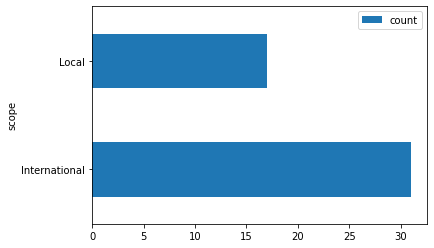

In [4]:
scope = get_research_relevance_scope(plot=True)

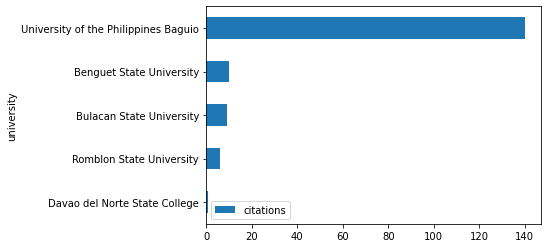

In [5]:
def get_research_relevance_citations(db_path='../data/db.sqlite3', 
                                     plot=False):
    """ counts the number of citations per SUC
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
                        
    Returns
    ===========
    get_research_relevance_citations    :   str
                                            json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT sc.school_name as university,
           SUM(jo.no_citations) as citations
    FROM (SELECT school_id, journal_id FROM research_profile
          GROUP BY research_title, school_id, journal_id) rp
    LEFT OUTER JOIN school sc
    on rp.school_id = sc.school_id
    LEFT OUTER JOIN journal jo
    on rp.journal_id = jo.journal_id
    WHERE jo.no_citations IS NOT NULL
    GROUP BY university
    ORDER BY citations ASC
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn).set_index('university')
    
    if plot:    
        df.plot.barh()
        plt.show()

    return df.to_json(orient='columns')

citations = get_research_relevance_citations(plot=True)

## Patents

In [6]:
def get_patent_table(db_path='../data/db.sqlite3',
                     show=False):
    """ outputs a table with columns: patent_filed, patent_type, status, 
        date_register, author, school
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    show         :      bool
                        print table if set to true
                        
    Returns
    ===========
    get_patent_table    :   str
                            json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT  pt.patent_filed as `Patent Filed`,
            pt.patent_type as `Patent Type`,
            pt.patent_status as Status, 
            pt.date_register as `Registration Date`,
            pt.registration_number as `Registration Number`,
            GROUP_CONCAT(author_name, ";") as Author, 
            school_name as University
    FROM patent pt
    LEFT OUTER JOIN author au
    on pt.author_id = au.author_id
    LEFT OUTER JOIN school sc
    ON pt.school_id = sc.school_id
    GROUP BY `Patent Filed`, `Patent Type`, Status, 
             `Registration Date`, `Registration Number`, 
              University
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
        
    if show:
        display(df)
        
    return df
    
patent = get_patent_table(show=True)

,Patent Filed,Patent Type,Status,Registration Date,Registration Number,Author,University
0,A Composition And For Making Red Dragon Fruit ...,Utility Model,Published,2019-06-25,2-2019-000764,"Somyden, Jao-Jao A.",Benguet State University
1,A Composition And Process Of Making Chickpea O...,Utility Model,Published,2018-12-20,2-2018-001616,"Gonzales, Ines C.",Benguet State University
2,A Composition And Process Of Making Enriched W...,Utility Model,Published,2018-12-20,2-2018-001617,"Gonzales, Ines C.",Benguet State University
3,A Composition And Process Of Making Polvoron E...,Utility Model,Published,2018-12-20,2-2018-001615,"Gonzales, Ines C.",Benguet State University
4,A Composition And Process Of Making Polvoron F...,Utility Model,Published,2019-06-25,2-2019-000763,"Somyden, Jao-Jao A.",Benguet State University
...,...,...,...,...,...,...,...
193,The Process of Making Rice Straw Geotextile Mat,Utility Model,Registered,2015-04-29,2-2014-000459,"Javellonar, Rolando, P.",Romblon State University
194,Tissue Culture Method Use In Producing Chayote...,Utility Model,Registered,2016-06-13,2-2016-000341,"Dumaslan, Milagros B.",Benguet State University
195,Tub-oy: Building Self-Reliant Communities for ...,Copyright,Registered,2015-09-28,ISBN 978-971-94317-8-7 / A2015-1502,"Lucidos, Juniel, G.",Romblon State University
196,Workbook in Physics,Copyright,Registered,2019-03-22,O-2019-799,"Ester, Forlales, L.",Romblon State University


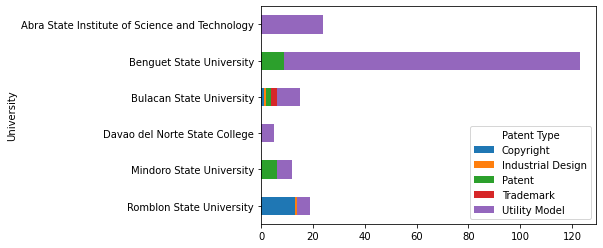

In [7]:
def get_patent_type_univ(db_path='../data/db.sqlite3',
                    plot=False):
    """ count the number of research type per university
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
                        
    Returns
    ===========
    get_patent_type_univ    :   str
                                json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT  pt.patent_filed as `Patent Filed`,
            pt.patent_type as `Patent Type`,
            pt.patent_status as Status, 
            pt.date_register as `Registration Date`,
            pt.registration_number as `Registration Number`,
            GROUP_CONCAT(author_name, ";") as Author, 
            school_name as University
    FROM patent pt
    LEFT JOIN author au
    on pt.author_id = au.author_id
    LEFT JOIN school sc
    ON pt.school_id = sc.school_id
    GROUP BY `Patent Filed`, `Patent Type`, Status, 
             `Registration Date`, `Registration Number`, 
              University
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)

    df = pd.crosstab(df.University, 
                     df['Patent Type']).sort_index(ascending=False)
    if plot:
        df.plot.barh(stacked=True)
        plt.show()
        
    return df.to_json(orient='columns')

patent_type_univ = get_patent_type_univ(plot=True)

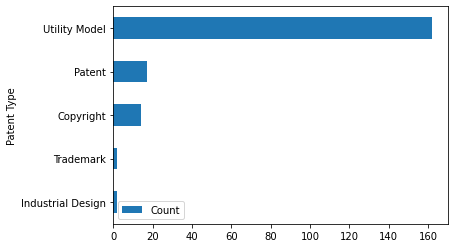

In [8]:
def get_patent_type(db_path='../data/db.sqlite3',
                    plot=False):
    """ count the number of research type
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
                        
    Returns
    ===========
    get_patent_type    :   str
                           json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT patent_type AS `Patent Type`, 
           COUNT(patent_type) as Count
    FROM
    (
        SELECT patent_type
        FROM patent 
        GROUP BY patent_filed, patent_type
    )
    GROUP BY patent_type
    ORDER BY Count
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn).set_index('Patent Type')

    if plot:
        df.plot.barh()
        plt.show()
        
    return df.to_json(orient='columns')

patent_type = get_patent_type(plot=True)

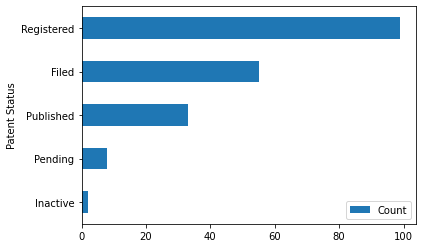

In [9]:
def get_patent_status(db_path='../data/db.sqlite3',
                      plot=False):
    """ count the number of research status
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
                        
    Returns
    ===========
    get_patent_status    :   str
                             json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT patent_status AS `Patent Status`, 
           COUNT(patent_status) as Count
    FROM
    (
        SELECT patent_status
        FROM patent 
        GROUP BY patent_filed, patent_status
    )
    GROUP BY patent_status
    ORDER BY Count
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn).set_index('Patent Status')

    if plot:
        df.plot.barh()
        plt.show()
        
    return df.to_json(orient='columns')

patent_status = get_patent_status(plot=True)

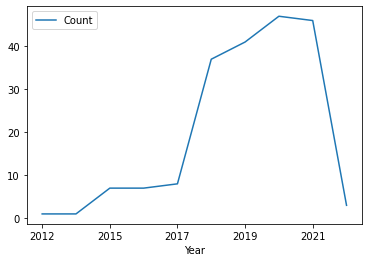

In [10]:
def get_patent_yearly(db_path='../data/db.sqlite3',
                      plot=False):
    """ count the number of patents per year
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
                        
    Returns
    ===========
    get_patent_yearly    :   str
                             json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT SUBSTR(date_register, 1, 4) AS Year, 
           COUNT(*) as Count
    FROM
    (
        SELECT date_register
        FROM patent 
        GROUP BY patent_filed, date_register
    )
    GROUP BY Year
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn).set_index('Year')

    if plot:
        df.plot()
        plt.show()
        
    return df.to_json(orient='columns')

patent_yearly = get_patent_yearly(plot=True)

# Faculty

## Faculty Profile

In [22]:
def get_faculty_profile_table(db_path='../data/db.sqlite3',
                             show=False):
    """ outputs a table with columns: name, education, 
        position, interests
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    show         :      bool
                        print table if set to true
    
    Returns
    ===========
    get_faculty_profile_table    :   str
                                     json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT fa.faculty_name as Name,
           fa.highest_educ_attain as Education,
           fa.position as Position,
           fa.interests as Interests, 
           sc.school_name as University
    FROM faculty fa
    LEFT OUTER JOIN school sc
    on fa.school_id = sc.school_id
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)

    if show:
        display(df)
    return df.to_json(orient='columns')

faculty = get_faculty_profile_table(show=True)

,Name,Education,Position,Interests,University
0,"Peralta, Violeta T.",Masteral Degree,None,None,Abra State Institute of Science and Technology
1,"Abaca, Fe P.",Doctoral Degree,None,FilIndigenous Peoplesino Linguistic; Education,Mindoro State University
2,"Abacan, Mary Ann R.",Doctoral Degree,Associate Professor II,Pediatrics; Genetics,University of the Philippines Manila
3,"Abad, Cybele Lara R.",Doctoral Degree,Clinical Associate,Internal Medicine,University of the Philippines Manila
4,"Abalos, Michael Vene S.",Masteral Degree,None,Mathematics; Physics,Abra State Institute of Science and Technology
...,...,...,...,...,...
981,"Zerrudo, Luigi S.",Bachelors Degree,Instructor,Chemistry,Davao del Norte State College
982,"de Guzman, Bernadeth P.",Masteral Degree,None,Criminology,Mindoro State University
983,"de Guzman, Glanys Wajima Rocell A.",Masteral Degree,None,Criminology,Mindoro State University
984,"de la Vega, Shelley Ann F.",Doctoral Degree,Professor VI,Geriatrics,University of the Philippines Manila


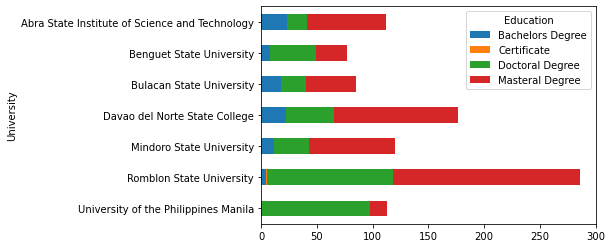

In [25]:
def get_faculty_educ_attain(db_path='../data/db.sqlite3',
                            plot=False):
    """ count the number of highest educ attainment per university
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
    
    Returns
    ===========
    get_faculty_profile_table    :   str
                                     json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT sc.school_name as University,
           fa.highest_educ_attain as Education
    FROM faculty fa
    LEFT OUTER JOIN school sc
    on fa.school_id = sc.school_id
    """
    
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    
    df = pd.crosstab(df.University, 
                     df.Education).sort_index(ascending=False)
    if plot:
        df.plot.barh(stacked=True)
        plt.show()

    return df.to_json(orient='columns')

educ_attain = get_faculty_educ_attain(plot=True)

# Metrics

## Research Cost

In [11]:
def get_research_cost_table(db_path='../data/db.sqlite3',
                        show=False):
    """ outputs a table with columns: title, author, university, budget, 
        funding agency, source, funding type
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    show         :      bool
                        print table if set to true
    
    Returns
    ===========
    get_research_cost_table    :   str
                                   json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT rp.research_title as Title,
           group_concat(au.author_name, ";") as Author,
           sc.school_name as University,
           rp.allocated_budget as Budget, 
           fa.fa_name as `Funding Agency`,
           bs.bs_name as Source, 
           ft.ft_name as `Funding Type`
    FROM research_profile rp
    LEFT OUTER JOIN author au
    on rp.author_id = au.author_id
    LEFT OUTER JOIN school sc
    on rp.school_id = sc.school_id
    LEFT OUTER JOIN funding_agency fa
    on rp.fa_id = fa.fa_id
    LEFT OUTER JOIN budget_source bs
    on rp.bs_id = bs.bs_id
    LEFT OUTER JOIN funding_type ft
    on rp.ft_id = ft.ft_id
    GROUP BY title, university, budget, `Funding Agency`, 
             source, `Funding Type`
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)

    if show:
        display(df)
    return df.to_json(orient='columns')

cost = get_research_cost_table(show=True)

,Title,Author,University,Budget,Funding Agency,Source,Funding Type
0,"""Concern for Community"": Case of cooperatives ...","Launio, Cheryll C.;Sotelo, Marycris",Benguet State University,39000,BSU,Internal,Grant
1,"""Wat Ta Iman Supsuplay (We Are But Supplied Fa...","Sagayo, Nora C.;Lorenzo, Roji Mae B.",None,None,None,None,None
2,(Dis)playing the Indigenous Body: the case of ...,"Queri, Shekinah Dorelle P.",University of the Philippines Baguio,None,None,None,None
3,"*Seagrass Filefish, Acreichthys tomentosus(Lin...","Gumanao, Girley S.;Bos, Arthur R.;Randall, Jac...",Davao del Norte State College,150000,DNSC,Internal,Grant
4,21st Century Skills and Readiness of Preservic...,"Somosot, Ian S.",Davao del Norte State College,8000,DNSC,Internal,Grant
...,...,...,...,...,...,...,...
1250,Wortkshop Training For Confidennce Building Am...,"Villegas, Melvin D.",Bulacan State University,None,None,None,None
1251,Wound Healing Efficacy of the combined aqueous...,"Sespene, Monica Joyce S.;Valdestamon, Revie Cl...",Palawan State University,None,None,Internal,None
1252,Yield Prediction Of Rice Using Random Forest A...,"Suarez, Jane Kristine G.",Bulacan State University,849600,DAR Region III,External,Grant
1253,Yield improvement with compost amendment and T...,"Lagman Jr., Cirilo A.;Cuevas, Virginia C.;Anup...",None,None,None,None,None


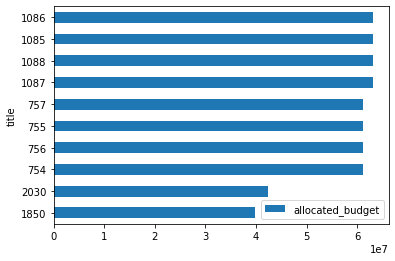

In [12]:
def get_research_cost_budget(db_path='../data/db.sqlite3',
                             top=10,
                             plot=False):
    """ get the top budget for research
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    top          :      int
                        top n 
    plot         :      bool
                        display plot if set to true

    Returns
    ===========
    get_research_cost_budget    :   str
                                    json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT rp.research_id as title, rp.allocated_budget
    FROM research_profile rp
    WHERE rp.allocated_budget IS NOT NULL
    GROUP BY title, rp.allocated_budget
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    
    df['allocated_budget'] = (df.allocated_budget.astype(str)
                                .str.split(';')
                                 .apply(lambda x: 
                                        sum([float(re.sub(r'[^0-9]','',i)) 
                                             for i in x])))
    
    df = df.sort_values(by='allocated_budget', ascending=False)[:top][::-1]
    df = df.set_index('title')
    if plot:
        df.plot.barh()
        plt.show()
    return df.to_json(orient='columns')

budget = get_research_cost_budget(plot=True)

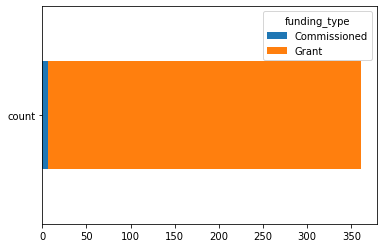

In [13]:
def get_research_cost_funding_type(db_path='../data/db.sqlite3',
                               plot=False):
    """ get the count of funding type as either commissioned or grant
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
    
    Returns
    ===========
    get_research_cost_table    :   str
                                   json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT ft.ft_name as funding_type,
           COUNT(ft.ft_name) as count
    FROM (SELECT ft_id FROM research_profile
          GROUP BY research_title, ft_id) rp
    LEFT OUTER JOIN funding_type ft
    on rp.ft_id = ft.ft_id
    WHERE rp.ft_id IS NOT NULL
    GROUP BY ft.ft_name
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    
    df = df.set_index('funding_type').T
    
    if plot:
        df.plot.barh(stacked=True)
        plt.show()

    return df.to_json(orient='columns')

funding_type = get_research_cost_funding_type(plot=True)

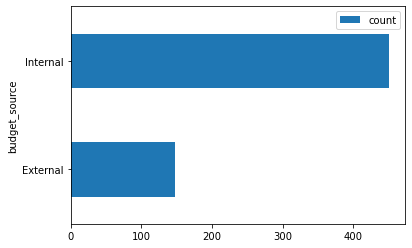

In [14]:
def get_research_cost_funding_source(db_path='../data/db.sqlite3',
                                 plot=False):
    """ get the count of funding source of the research
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
    
    Returns
    ===========
    get_research_cost_funding_source    :   str
                                            json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT bs.bs_name as budget_source,
           COUNT(bs.bs_name) as count
    FROM (SELECT bs_id FROM research_profile
          GROUP BY research_title, bs_id) rp
    LEFT OUTER JOIN budget_source bs
    on rp.bs_id = bs.bs_id
    WHERE rp.bs_id IS NOT NULL
    GROUP BY bs.bs_name
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    
    df = df.set_index('budget_source')
    
    if plot:
        df.plot.barh()
        plt.show()

    return df.to_json(orient='columns')


funding_source = get_research_cost_funding_source(plot=True)

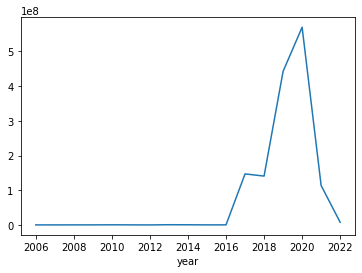

In [27]:
def get_research_cost_budget_line(db_path='../data/db.sqlite3',
                              plot=False):
    """ get the yearly budget for research 
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
    
    Returns
    ===========
    get_research_cost_budget_line    :   str
                                         json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT rp.research_id as title, 
           rp.year as year, 
           rp.allocated_budget
    FROM research_profile rp
    WHERE rp.allocated_budget IS NOT NULL
    GROUP BY title, rp.year, rp.allocated_budget
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
    
    df['allocated_budget'] = (df.allocated_budget.astype(str)
                                .str.split(';')
                                 .apply(lambda x: 
                                        sum([float(re.sub(r'[^0-9]','',i)) 
                                             for i in x])))
    
    df = df.sort_values(by='allocated_budget', ascending=False)
    df = df.set_index('title')
    df = df.groupby('year')['allocated_budget'].sum()
    df.index = df.index.astype(int)
    
    if plot:
        df.plot()
        plt.show()
    return df.to_json(orient='columns')

budget = get_research_cost_budget_line(plot=True)

## Utilization

In [16]:
def get_utilization_table(db_path='../data/db.sqlite3',
                          show=False):
    """ outputs a table with columns: patent_filed, patent_type, status, 
        date_register, author, school
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    show         :      bool
                        print table if set to true
                        
    Returns
    ===========
    get_utilization_table    :   str
                                 json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT  ut.product_service as Product,
            ut.beneficiary as Beneficiary,
            ut.year as Year, 
            sc.school_name as University
    FROM utilization ut
    LEFT OUTER JOIN school sc
    ON ut.school_id = sc.school_id
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)
        
    if show:
        display(df)

    return df
    
utilization = get_utilization_table(show=True)

,Product,Beneficiary,Year,University
0,Technology In Growing Traditional Rice,Francisca M. Badua,2018,Agusan del Sur State College of Agriculture an...
1,Growth Media From Organic Waste,Loreta B. Alayon; Flora Anisco; Felicidad D. A...,2018,Agusan del Sur State College of Agriculture an...
2,Fertilizer For Banana,Farmers Association of lower Agpan; Imelda Tec...,2018,Agusan del Sur State College of Agriculture an...
3,Mobile Application,Indigent People,2019,Agusan del Sur State College of Agriculture an...
4,Mobile Application,Teachers,2019,Agusan del Sur State College of Agriculture an...
...,...,...,...,...
95,The Prototype Itself,"BulSU Students (BSIT, CIT, and Eng'g)",2018,Bulacan State University
96,Kostal Aralan,Taliptip Elementary School Students living in ...,2017,Bulacan State University
97,Educational Organization,Teachers; Students,2018,Bulacan State University
98,Seminar For Education Students,Education Students,2021,Bulacan State University


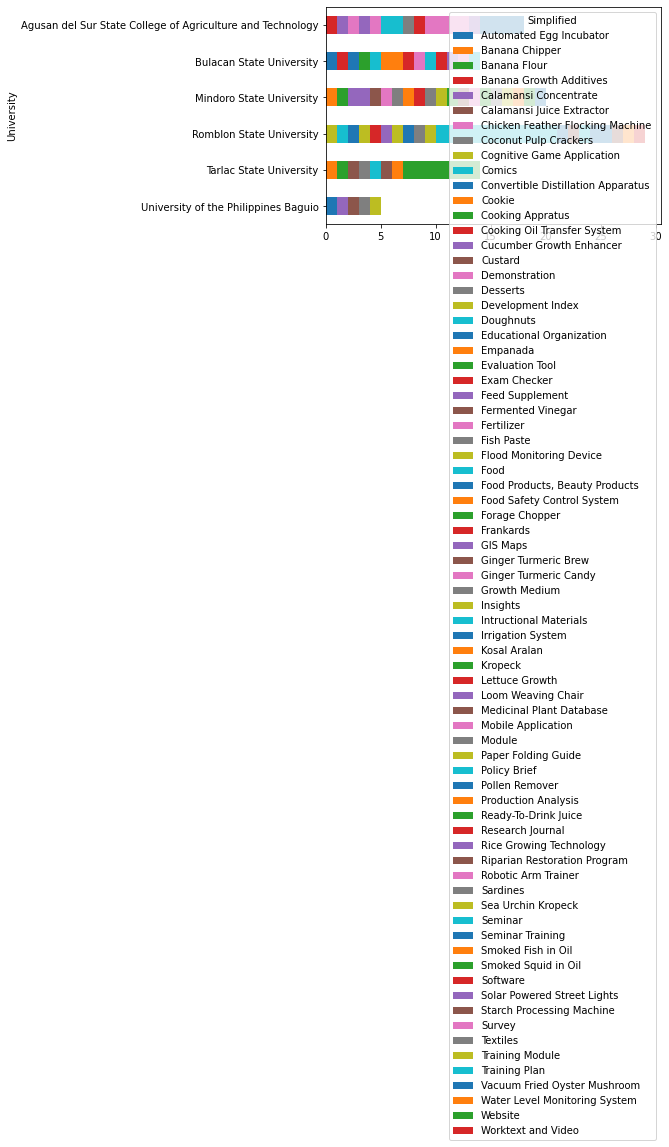

In [28]:
def get_utilization_product_univ(db_path='../data/db.sqlite3',
                    plot=False):
    """ count the number of product/service type per university
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
                        
    Returns
    ===========
    get_utilization_product_univ    :   str
                                        json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT  ut.product_service as Product,
            sc.school_name as University
    FROM utilization ut
    LEFT JOIN school sc
    ON ut.school_id = sc.school_id
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)

    df = pd.crosstab(df.University, 
                     df.Product).sort_index(ascending=False)
    if plot:
        df.plot.barh(stacked=True)
        plt.show()
        
    return df.to_json(orient='columns')

util_prod_univ = get_utilization_product_univ(plot=True)

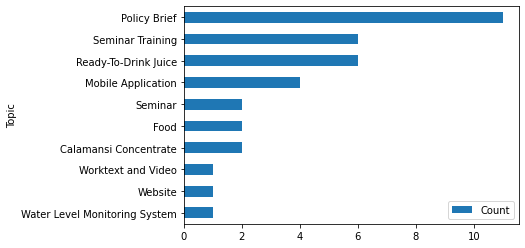

In [18]:
def get_utilization_topics(db_path='../data/db.sqlite3',
                           top=10,
                           plot=False):
    """ get the top n utilization topics
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
                        
    Returns
    ===========
    get_utilization_topics    :   str
                                  json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT ut.Simplified as Topic, 
           COUNT(ut.Simplified) as Count
    FROM utilization ut
    GROUP BY ut.Simplified
    ORDER BY Count DESC
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn).set_index('Topic')[:top][::-1]

    if plot:
        df.plot.barh()
        plt.show()
        
    return df.to_json(orient='columns')

utilization_topics = get_utilization_topics(plot=True)

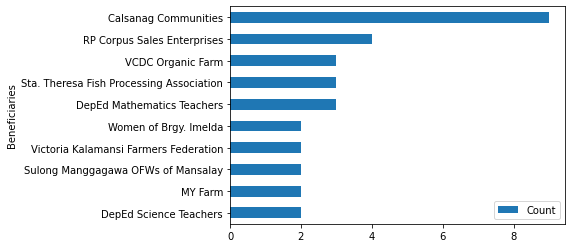

In [19]:
def get_utilization_beneficiaries(db_path='../data/db.sqlite3',
                                  top=10,
                                  plot=False):
    """ get the top n beneficiaries
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
                        
    Returns
    ===========
    get_utilization_beneficiaries    :   str
                                         json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT ut.beneficiary as Beneficiaries, 
           COUNT(ut.beneficiary) as Count
    FROM utilization ut
    GROUP BY ut.beneficiary
    ORDER BY Count DESC
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn).set_index('Beneficiaries')[:top][::-1]

    if plot:
        df.plot.barh()
        plt.show()
        
    return df.to_json(orient='columns')

utilization_benef = get_utilization_beneficiaries(plot=True)

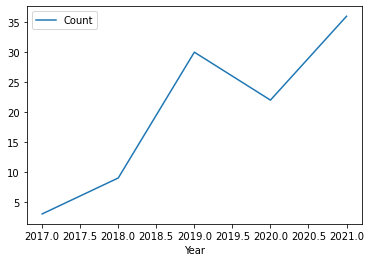

In [20]:
def get_utilization_yearly(db_path='../data/db.sqlite3',
                           plot=False):
    """ get the yearly utilization count
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    plot         :      bool
                        display plot if set to true
                        
    Returns
    ===========
    get_utilization_yearly    :   str
                                  json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT ut.year as Year, 
           COUNT(ut.year) as Count
    FROM utilization ut
    GROUP BY ut.year
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn).set_index('Year')

    if plot:
        df.plot()
        plt.show()
        
    return df.to_json(orient='columns')

utilization_yearly = get_utilization_yearly(plot=True)

## Regional Development

In [21]:
def get_regional_development_table(db_path='../data/db.sqlite3',
                                 show=False):
    """ outputs a table with columns: title, author, university, budget, 
        funding agency, source, funding type
    
    Parameters
    ===========
    db_path      :      str
                        path of sqlite database
    show         :      bool
                        print table if set to true
    
    Returns
    ===========
    get_regional_development_table    :   str
                                          json string
    """
    engine = create_engine('sqlite:///' + db_path)
    query = """
    SELECT rp.research_title as Title,
           sc.school_name as University,
           group_concat(au.author_name, ";") as Author,
           rp.neda_id, 
           rp.sdg_id
    FROM research_profile rp
    LEFT OUTER JOIN author au
    on rp.author_id = au.author_id
    LEFT OUTER JOIN school sc
    on rp.school_id = sc.school_id
    GROUP BY title, university, rp.neda_id, rp.sdg_id
    """
    with engine.connect() as conn:
        df = pd.read_sql(query, conn)

    if show:
        display(df)
    return df.to_json(orient='columns')


rr_table = get_research_relevance_table(show=True)

,Title,Author,University,Journal,Year Published,Scope,Citations
0,"""Concern for Community"": Case of cooperatives ...","Launio, Cheryll C.;Sotelo, Marycris",Benguet State University,None,NaN,None,NaN
1,"""Wat Ta Iman Supsuplay (We Are But Supplied Fa...","Sagayo, Nora C.;Lorenzo, Roji Mae B.",None,None,NaN,None,NaN
2,(Dis)playing the Indigenous Body: the case of ...,"Queri, Shekinah Dorelle P.",University of the Philippines Baguio,None,NaN,None,NaN
3,"*Seagrass Filefish, Acreichthys tomentosus(Lin...","Gumanao, Girley S.;Bos, Arthur R.;Randall, Jac...",Davao del Norte State College,Journal of Ocean Science Foundation,2018.0,International,1.0
4,21st Century Skills and Readiness of Preservic...,"Somosot, Ian S.",Davao del Norte State College,None,NaN,None,NaN
...,...,...,...,...,...,...,...
1250,Wortkshop Training For Confidennce Building Am...,"Villegas, Melvin D.",Bulacan State University,None,NaN,None,NaN
1251,Wound Healing Efficacy of the combined aqueous...,"Sespene, Monica Joyce S.;Valdestamon, Revie Cl...",Palawan State University,None,NaN,None,NaN
1252,Yield Prediction Of Rice Using Random Forest A...,"Suarez, Jane Kristine G.",Bulacan State University,None,NaN,None,NaN
1253,Yield improvement with compost amendment and T...,"Lagman Jr., Cirilo A.;Cuevas, Virginia C.;Anup...",None,None,NaN,None,NaN
